In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#Importing all the libraries that I use in this project
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
#Loding data into the kernels 

file_path_with_infertility="D:\PatientDisease\PCOS_infertility.csv"
file_path_without_infertility="D:\PatientDisease\PCOS_data_without_infertility.xlsx"

PCOS_inf = pd.read_csv(file_path_with_infertility)
PCOS_woinf = pd.read_excel(file_path_without_infertility, sheet_name="Full_new")

**<span style="color:teal;"> Merging the two files as per patient file no. and dropping the repeated features</span>**

In [4]:
#Merging the two files as per patient file no. 
#The files were sorted into two based on patients with infertility and without infertility
data = pd.merge(PCOS_woinf,PCOS_inf, on='Patient File No.', suffixes={'','_y'},how='left')

#Dropping the repeated features after merging
data =data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y',
       'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)

#Taking a look at the dataset
data.head()

C:\Users\sanje\AppData\Local\Temp\ipykernel_27868\1299048099.py:3: FutureWarning: Passing 'suffixes' as a <class 'set'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  data = pd.merge(PCOS_woinf,PCOS_inf, on='Patient File No.', suffixes={'','_y'},how='left')


,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,1,1,0,28,44.6,152.0,19.300000,15,78,22,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,2,2,0,36,65.0,161.5,24.921163,15,74,20,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,3,3,1,33,68.8,165.0,25.270891,11,72,18,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,4,4,0,37,65.0,148.0,29.674945,13,72,20,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,5,5,0,25,52.0,161.0,20.060954,11,72,18,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0


Everything looks alright we can work with this.

We have a dataset of shape 5 rows × 44 columns.

Let's head up to the next step and have a further look at the data.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 540
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3    Age (yrs)              541 non-null    int64  
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    int64  
 8   Pulse rate(bpm)         541 non-null    int64  
 9   RR (breaths/min)        541 non-null    int64  
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    int64  
 12  Cycle length(days)      541 non-null    int64  
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    in

**<span style="color:teal;"> Encoding categorical variables (dtype objects)</span>**

In [6]:
#Having a look at the data with dtype objects

data["AMH(ng/mL)"].head()

0    2.07
1    1.53
2    6.63
3    1.22
4    2.26
Name: AMH(ng/mL), dtype: object

In [7]:
#Similarly

data["II    beta-HCG(mIU/mL)"].head()

0      1.99
1      1.99
2    494.08
3      1.99
4    801.45
Name: II    beta-HCG(mIU/mL), dtype: object

After having a look at this info we may conclude that:

* Some numeric data are saved as strings.
* There are some missing values. Namely, Marriage Status (Yrs)& Fast food (Y/N)

In [8]:
#Dealing with categorical values.
#In this database the type objects are numeric values saved as strings.
#So I am just converting it into a numeric value.

data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')

#Dealing with missing values. 
#Filling NA values with the median of that feature.

data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(),inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(),inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(),inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(),inplace=True)

#Clearing up the extra space in the column names (optional)

data.columns = [col.strip() for col in data.columns]

In [9]:
# Having a look at some basic statistical details.

data.describe()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,...,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,271.000000,271.000000,0.327172,31.430684,59.637153,156.484835,24.311285,13.802218,73.247689,19.243993,...,0.489834,0.515712,0.247689,114.661738,76.927911,6.129390,6.641405,15.018115,15.451701,8.475915
std,156.317519,156.317519,0.469615,5.411006,11.028287,6.033545,4.056399,1.840812,4.430285,1.688629,...,0.500359,0.500216,0.432070,7.384556,5.574112,4.229294,4.436889,3.566839,3.318848,2.165381
min,1.000000,1.000000,0.000000,20.000000,31.000000,137.000000,12.417882,11.000000,13.000000,16.000000,...,0.000000,0.000000,0.000000,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,136.000000,136.000000,0.000000,28.000000,52.000000,152.000000,21.641274,13.000000,72.000000,18.000000,...,0.000000,0.000000,0.000000,110.000000,70.000000,3.000000,3.000000,13.000000,13.000000,7.000000
50%,271.000000,271.000000,0.000000,31.000000,59.000000,156.000000,24.238227,14.000000,72.000000,18.000000,...,0.000000,1.000000,0.000000,110.000000,80.000000,5.000000,6.000000,15.000000,16.000000,8.500000
75%,406.000000,406.000000,1.000000,35.000000,65.000000,160.000000,26.634958,15.000000,74.000000,20.000000,...,1.000000,1.000000,0.000000,120.000000,80.000000,9.000000,10.000000,18.000000,18.000000,9.800000
max,541.000000,541.000000,1.000000,48.000000,108.000000,180.000000,38.900000,18.000000,82.000000,28.000000,...,1.000000,1.000000,1.000000,140.000000,100.000000,22.000000,20.000000,24.000000,24.000000,18.000000


In [10]:
#Added in the recent update. 
#This came upon evaluating the dataset some obvious outliers I am not explaining the process I used. 
#Dropping the outliers. 

data = data[(data["BP _Diastolic (mmHg)"]>20)]
data = data[(data["AMH(ng/mL)"]<40)]
data = data[(data["BP _Systolic (mmHg)"]>20)]
data = data[(data["Endometrium (mm)"]>0)]
data = data[(data["Avg. F size (R) (mm)"]>0)]
data = data[(data["Avg. F size (R) (mm)"]>0)]
data = data[(data["RBS(mg/dl)"]<200)]
data = data[(data["PRG(ng/mL)"]<20)]
data = data[(data["Pulse rate(bpm)"]>20)]
data = data[(data["FSH(mIU/mL)"]<4000)]
data = data[(data["LH(mIU/mL)"]<1500)]
data = data[(data["Cycle(R/I)"]<4.5)]

data.shape

(526, 44)

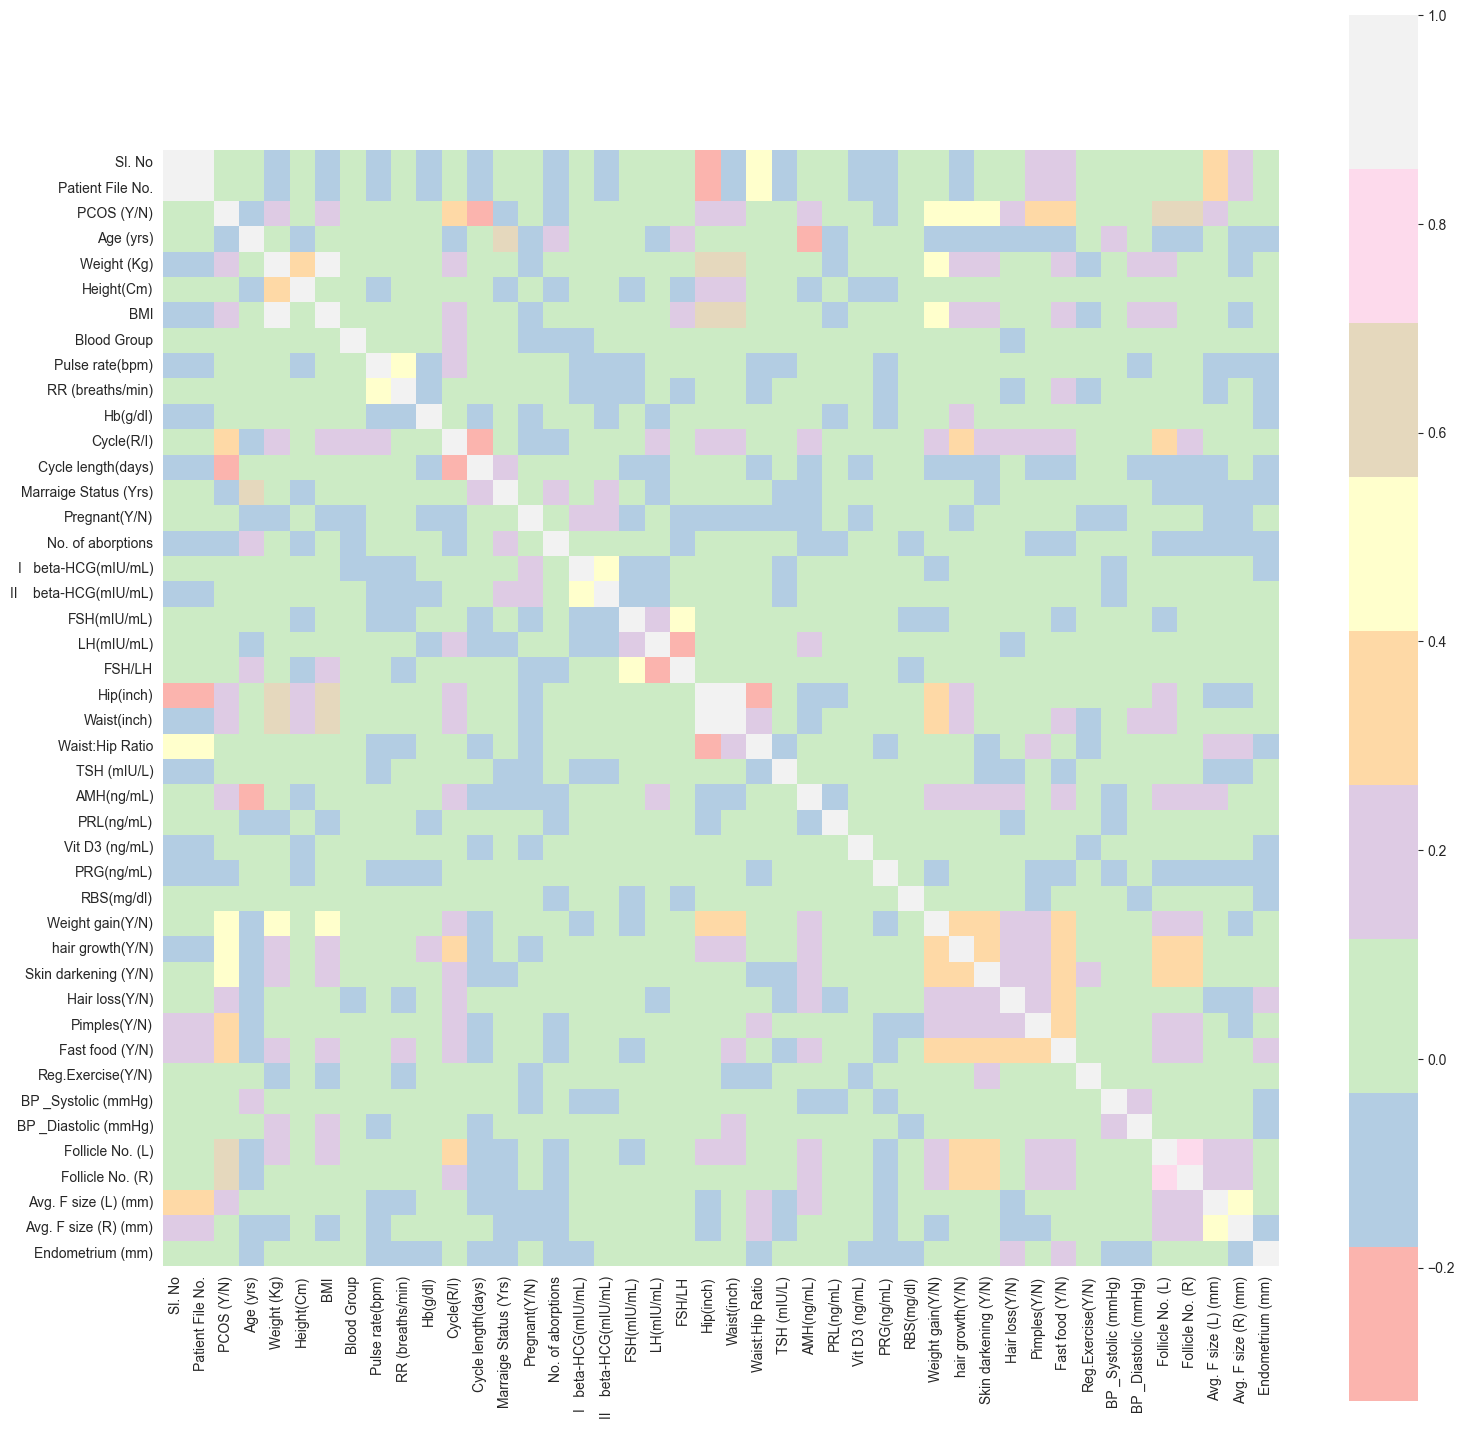

In [11]:
#Examaning a correlation matrix of all the features 

corrmat = data.corr()
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap="Pastel1", square=True);

In [12]:
#How all the features correlate with the PCOS 

corrmat["PCOS (Y/N)"].sort_values(ascending=False)

PCOS (Y/N)                1.000000
Follicle No. (R)          0.650915
Follicle No. (L)          0.605305
Skin darkening (Y/N)      0.474561
hair growth(Y/N)          0.463557
Weight gain(Y/N)          0.445646
Cycle(R/I)                0.404082
Fast food (Y/N)           0.376877
Pimples(Y/N)              0.295313
AMH(ng/mL)                0.261105
Weight (Kg)               0.210241
BMI                       0.194121
Hair loss(Y/N)            0.176603
Hip(inch)                 0.163335
Waist(inch)               0.160226
Avg. F size (L) (mm)      0.124990
Pulse rate(bpm)           0.102988
LH(mIU/mL)                0.095426
Hb(g/dl)                  0.094481
Vit D3 (ng/mL)            0.086052
Endometrium (mm)          0.085608
Avg. F size (R) (mm)      0.084756
Height(Cm)                0.075431
Reg.Exercise(Y/N)         0.061816
Sl. No                    0.051936
Patient File No.          0.051936
FSH/LH                    0.043591
Blood Group               0.043032
RR (breaths/min)    

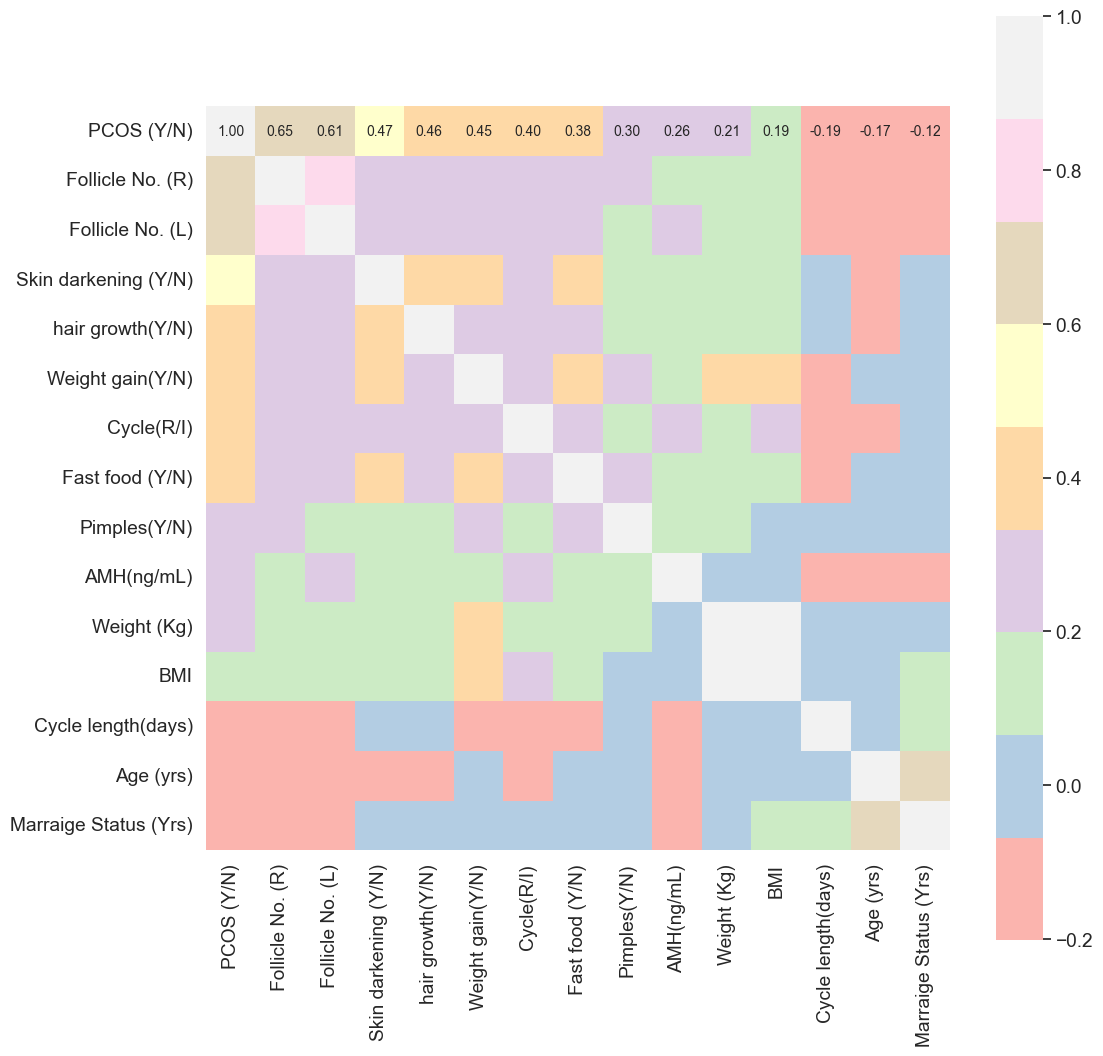

In [13]:
#Having a look at features bearing significant correlation

plt.figure(figsize=(12,12))
k = 12 #number of variables with positive for heatmap
l = 3 #number of variables with negative for heatmap
cols_p = corrmat.nlargest(k, "PCOS (Y/N)")["PCOS (Y/N)"].index 
cols_n = corrmat.nsmallest(l, "PCOS (Y/N)")["PCOS (Y/N)"].index
cols = cols_p.append(cols_n) 

cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True,cmap="Pastel1", annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

 **<span style="color:teal;"> Patterns Of Length Of The Menstrual Cycle </span>**

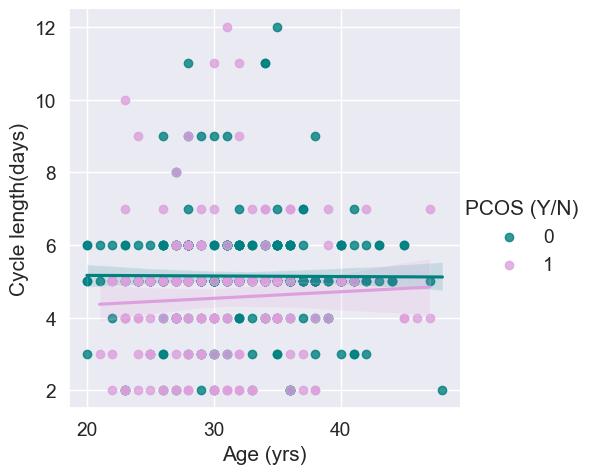

In [14]:
# Length of menstrual phase in PCOS vs normal 
color = ["teal", "plum"]
fig=sns.lmplot(data=data,x="Age (yrs)",y="Cycle length(days)", hue="PCOS (Y/N)",palette=color)
plt.show(fig)

The length of the menstrual phase is overall consistent over different ages for normal cases. Whereas in the case of PCOD the length increased with age. 

 **<span style="color:teal;"> Patterns Of BMI </span>**

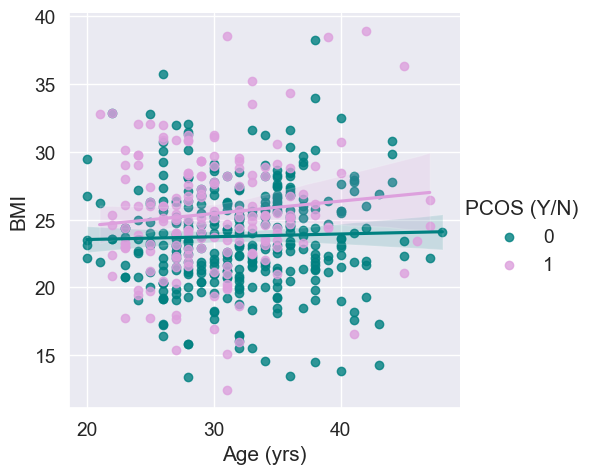

In [15]:
# Pattern of weight gain (BMI) over years in PCOS and Normal. 
fig= sns.lmplot(data =data,x="Age (yrs)",y="BMI", hue="PCOS (Y/N)", palette= color )
plt.show(fig)

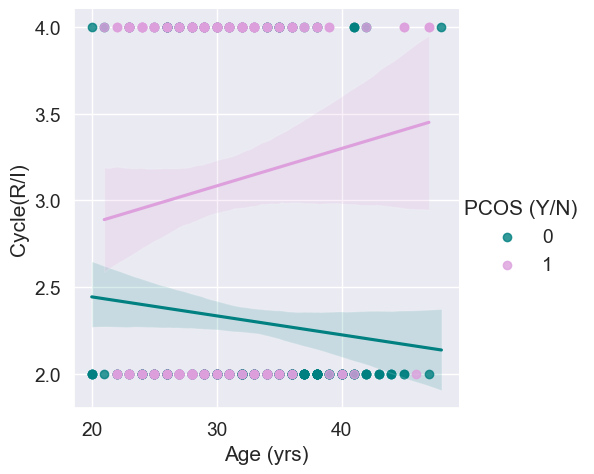

In [16]:
# cycle IR wrt age 
sns.lmplot(data =data,x="Age (yrs)",y="Cycle(R/I)", hue="PCOS (Y/N)",palette=color)
plt.show()

The mensural cycle becomes more regular for normal cases with age. Whereas, for PCOS the irregularity increases with age.

 **<span style="color:teal;"> Number Of Follicles </span>**

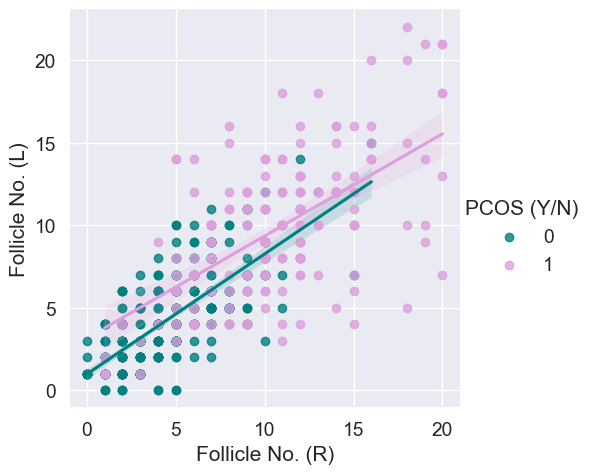

In [17]:
# Distribution of follicles in both ovaries. 
sns.lmplot(data =data,x='Follicle No. (R)',y='Follicle No. (L)', hue="PCOS (Y/N)",palette=color)
plt.show()

The distribution of follicles in both ovaries Left and Right are not equal for women with PCOS in comparison with the "Normal" patient. 
Thia is curious let's exlore it with boxen plot.

C:\Users\sanje\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 31.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


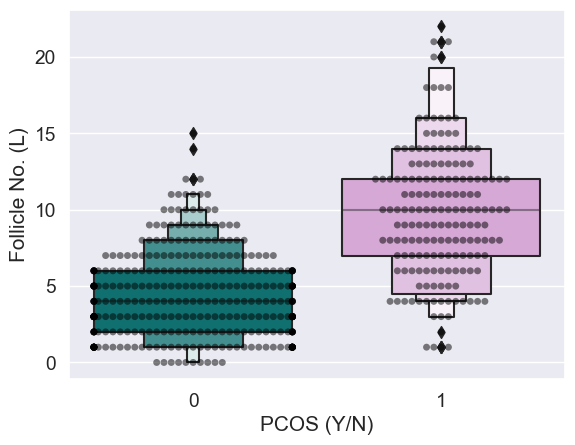

C:\Users\sanje\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 29.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


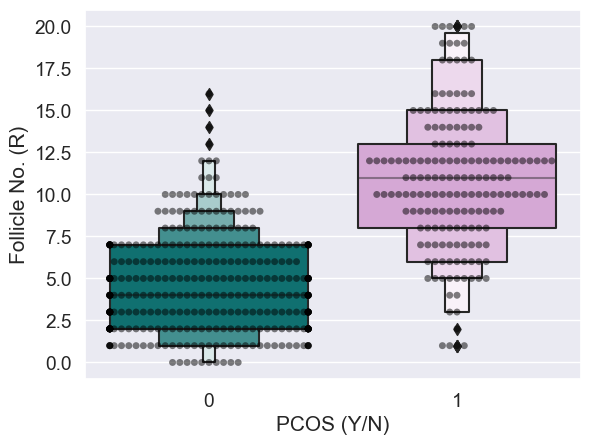

In [18]:
features = ["Follicle No. (L)","Follicle No. (R)"]
for i in features:
    sns.swarmplot(x=data["PCOS (Y/N)"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
    plt.show()

The number of follicles in women with PCOS is higher, as expected. And are unequal as well. 
 
**<span style="color:teal;"> Some Miscellaneous EDA </span>**

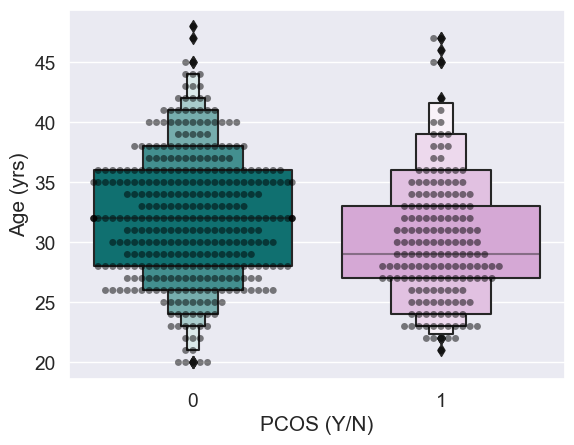

C:\Users\sanje\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 7.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


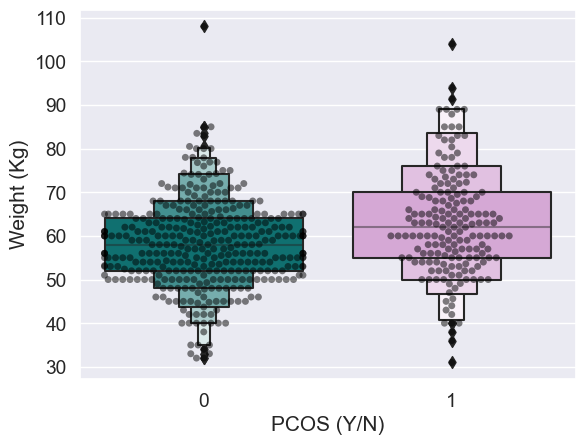

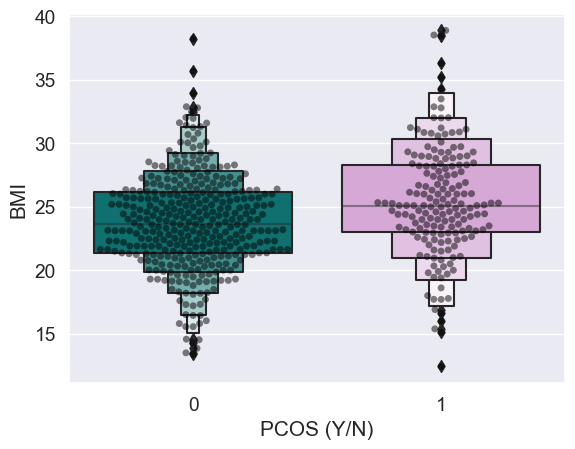

C:\Users\sanje\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 20.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


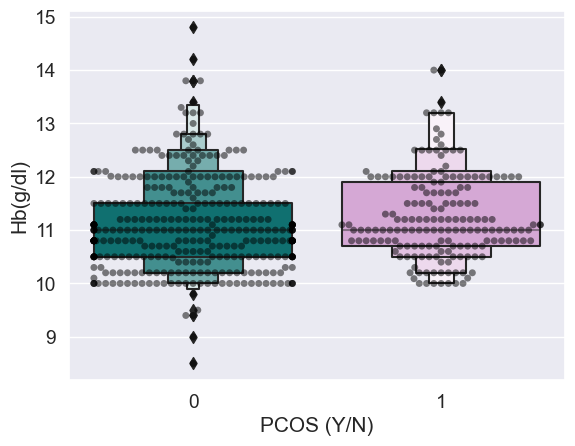

C:\Users\sanje\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 65.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\sanje\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 25.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


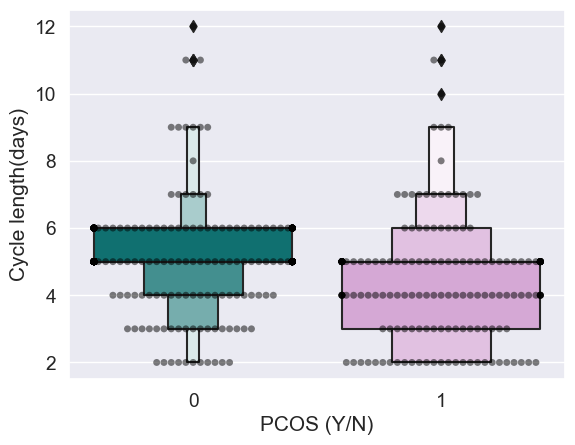

C:\Users\sanje\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 9.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


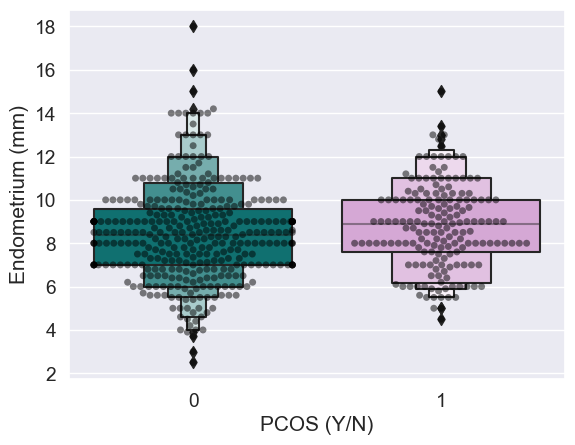

In [19]:
features = ["Age (yrs)","Weight (Kg)", "BMI", "Hb(g/dl)", "Cycle length(days)","Endometrium (mm)" ]
for i in features:
    sns.swarmplot(x=data["PCOS (Y/N)"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
    plt.show()

In [20]:
#Assiging the features (X)and target(y)

X=data.drop(["PCOS (Y/N)","Sl. No","Patient File No."],axis = 1) #droping out index from features too
y=data["PCOS (Y/N)"]

#Splitting the data into test and training sets

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

## Random Forest

In [21]:
#Fitting the RandomForestClassifier to the training set

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

#Making prediction and checking the test set

pred_rfc = rfc.predict(X_test)
accuracy = accuracy_score(y_test, pred_rfc)
print(accuracy)

0.8670886075949367


## ANN

C:\Users\sanje\AppData\Local\Temp\ipykernel_27868\2004917119.py:21: FutureWarning: Passing 'suffixes' as a <class 'set'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  data = pd.merge(PCOS_woinf, PCOS_inf, on='Patient File No.', suffixes={'','_y'}, how='left')


Epoch 1/100
10/10 [==============================] - 1s 19ms/step - loss: 0.6446 - accuracy: 0.6589 - val_loss: 0.5936 - val_accuracy: 0.7237
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5243 - accuracy: 0.7616 - val_loss: 0.5160 - val_accuracy: 0.7632
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 0.4439 - accuracy: 0.8311 - val_loss: 0.4557 - val_accuracy: 0.8158
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.3785 - accuracy: 0.8808 - val_loss: 0.4106 - val_accuracy: 0.8421
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 0.3265 - accuracy: 0.8808 - val_loss: 0.3761 - val_accuracy: 0.8421
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 0.2823 - accuracy: 0.9040 - val_loss: 0.3570 - val_accuracy: 0.8421
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 0.2452 - accuracy: 0.9073 - val_loss: 0.3429 - val_accuracy: 0.8553
Epoch 8/100


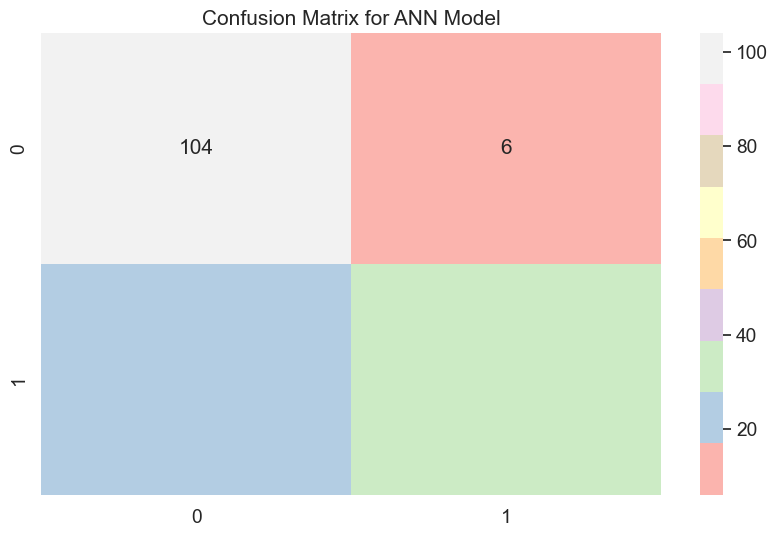

In [22]:
# Importing necessary libraries for Neural Networks
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Loading Data
file_path_with_infertility = "D:\PatientDisease\PCOS_infertility.csv"
file_path_without_infertility = "D:\PatientDisease\PCOS_data_without_infertility.xlsx"

PCOS_inf = pd.read_csv(file_path_with_infertility)
PCOS_woinf = pd.read_excel(file_path_without_infertility, sheet_name="Full_new")

# Merging the two files as per patient file no. and dropping the repeated features
data = pd.merge(PCOS_woinf, PCOS_inf, on='Patient File No.', suffixes={'','_y'}, how='left')
data = data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y',
                  'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)

# Dealing with categorical values and missing data
data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')
data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(), inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(), inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(), inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(), inplace=True)

# Assigning features (X) and target (y)
X = data.drop(["PCOS (Y/N)", "Sl. No", "Patient File No."], axis=1)
y = data["PCOS (Y/N)"]

# Splitting the data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling the data for better performance of the neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the ANN model
model = Sequential()

# Adding input layer and first hidden layer
model.add(Dense(units=64, activation='relu', input_dim=X_train_scaled.shape[1]))

# Adding second hidden layer
model.add(Dense(units=32, activation='relu'))

# Adding the output layer (for binary classification)
model.add(Dense(units=1, activation='sigmoid'))

# Compiling the ANN
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the ANN on the training set
history = model.fit(X_train_scaled, y_train, batch_size=32, epochs=100, validation_split=0.2)

# Making predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary classification (0 or 1)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Confusion matrix
plt.figure(figsize=(10,6))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap="Pastel1", fmt='g')
plt.title('Confusion Matrix for ANN Model')
plt.show()


In [ ]:
# Re-importing necessary libraries to ensure variables are loaded correctly
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Loading Data again for the test
file_path_with_infertility = 'D:\PatientDisease\PCOS_infertility.csv'
file_path_without_infertility = 'D:\PatientDisease\PCOS_data_without_infertility.xlsx'

PCOS_inf = pd.read_csv(file_path_with_infertility)
PCOS_woinf = pd.read_excel(file_path_without_infertility, sheet_name="Full_new")

# Merging the two files as per patient file no. and dropping the repeated features
data = pd.merge(PCOS_woinf, PCOS_inf, on='Patient File No.', suffixes={'','_y'}, how='left')
data = data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y',
                  'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)

# Dealing with categorical values and missing data
data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')
data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(), inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(), inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(), inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(), inplace=True)

# Assigning features (X) and target (y)
X = data.drop(["PCOS (Y/N)", "Sl. No", "Patient File No."], axis=1)
y = data["PCOS (Y/N)"]

# Splitting the data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the ANN model
model = Sequential()

# Adding input layer and first hidden layer
model.add(Dense(units=64, activation='relu', input_dim=X_train_scaled.shape[1]))

# Adding second hidden layer
model.add(Dense(units=32, activation='relu'))

# Adding the output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compiling the ANN
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model (for the sake of example, I will use fewer epochs)
model.fit(X_train_scaled, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Now making the prediction for a single test row
single_test_data = X_test_scaled[100].reshape(1, -1)
single_prediction = model.predict(single_test_data)
single_prediction_label = "PCOS" if single_prediction > 0.5 else "No PCOS"

# Showing the actual label and the predicted label for the single test row
actual_label = y_test.iloc[100]
actual_label_str = "PCOS" if actual_label == 1 else "No PCOS"

# Displaying both actual and predicted labels
actual_label_str, single_prediction_label


## XGBoost

C:\Users\sanje\AppData\Local\Temp\ipykernel_27868\199731130.py:19: FutureWarning: Passing 'suffixes' as a <class 'set'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  data = pd.merge(PCOS_woinf, PCOS_inf, on='Patient File No.', suffixes={'','_y'}, how='left')
C:\Users\sanje\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:43:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8834355828220859
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       110
           1       0.84      0.79      0.82        53

    accuracy                           0.88       163
   macro avg       0.87      0.86      0.87       163
weighted avg       0.88      0.88      0.88       163


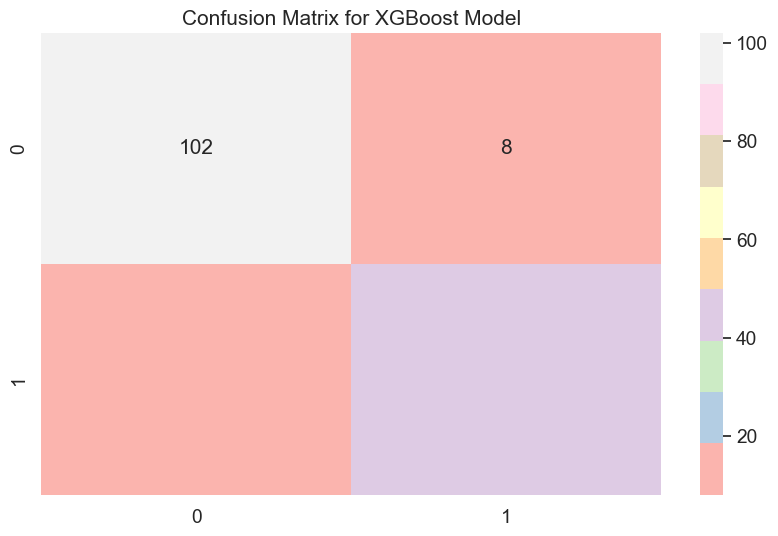

Actual Label: No PCOS
Predicted Label: No PCOS
Prediction Probabilities: [[0.56429744 0.43570253]]


In [24]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

# Loading Data
file_path_with_infertility = "D:\PatientDisease\PCOS_infertility.csv"
file_path_without_infertility = "D:\PatientDisease\PCOS_data_without_infertility.xlsx"

PCOS_inf = pd.read_csv(file_path_with_infertility)
PCOS_woinf = pd.read_excel(file_path_without_infertility, sheet_name="Full_new")

# Merging the two files as per patient file no. and dropping the repeated features
data = pd.merge(PCOS_woinf, PCOS_inf, on='Patient File No.', suffixes={'','_y'}, how='left')
data = data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y',
                  'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)

# Dealing with categorical values and missing data
data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')
data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(), inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(), inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(), inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(), inplace=True)

# Assigning features (X) and target (y)
X = data.drop(["PCOS (Y/N)", "Sl. No", "Patient File No."], axis=1)
y = data["PCOS (Y/N)"]

# Splitting the data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to a DataFrame (optional for interpretability)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model on the training data
xgb_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Confusion matrix
plt.figure(figsize=(10,6))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap="Pastel1", fmt='g')
plt.title('Confusion Matrix for XGBoost Model')
plt.show()

# Show the actual and predicted value for a single test row
# Show the actual and predicted value for a single test row
single_test_index = 0  # You can choose any index from the test set
single_test_data = X_test_scaled.iloc[single_test_index:single_test_index+1]

# Predicting the probability for the single test row
single_prediction_prob = xgb_model.predict_proba(single_test_data)
single_prediction_label = "PCOS" if single_prediction_prob[0][1] > 0.5 else "No PCOS"

# Getting the actual label for the same test row
actual_label = y_test.iloc[single_test_index]
actual_label_str = "PCOS" if actual_label == 1 else "No PCOS"

# Displaying both actual and predicted labels with probability
print(f"Actual Label: {actual_label_str}")
print(f"Predicted Label: {single_prediction_label}")
print(f"Prediction Probabilities: {single_prediction_prob}")



Epoch 1/100


C:\Users\sanje\AppData\Local\Temp\ipykernel_27868\1897946252.py:23: FutureWarning: Passing 'suffixes' as a <class 'set'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  data = pd.merge(PCOS_woinf, PCOS_inf, on='Patient File No.', suffixes={'','_y'}, how='left')


10/10 [==============================] - 0s 17ms/step - loss: 0.5720 - accuracy: 0.7616 - val_loss: 0.5711 - val_accuracy: 0.8289
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 0.4563 - accuracy: 0.8477 - val_loss: 0.5011 - val_accuracy: 0.8553
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 0.3781 - accuracy: 0.8775 - val_loss: 0.4486 - val_accuracy: 0.8684
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.3184 - accuracy: 0.9073 - val_loss: 0.4043 - val_accuracy: 0.8684
Epoch 5/100
10/10 [==============================] - 0s 3ms/step - loss: 0.2710 - accuracy: 0.9205 - val_loss: 0.3795 - val_accuracy: 0.8684
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 0.2376 - accuracy: 0.9272 - val_loss: 0.3649 - val_accuracy: 0.8553
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 0.2087 - accuracy: 0.9338 - val_loss: 0.3617 - val_accuracy: 0.8421
Epoch 8/100
10/10 [=====

C:\Users\sanje\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:44:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


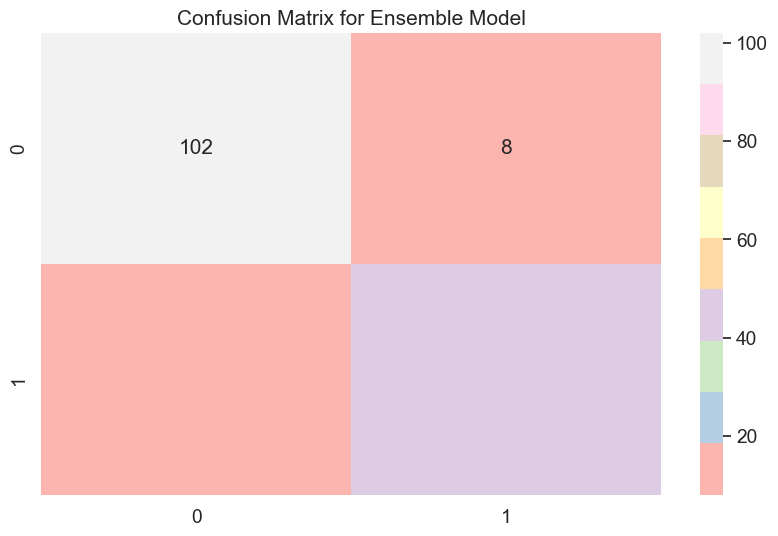

1/1 [==============================] - 0s 14ms/step
Actual Label: No PCOS
Predicted Label: No PCOS


In [25]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

# Loading Data
file_path_with_infertility = "D:\\PatientDisease\\PCOS_infertility.csv"
file_path_without_infertility = "D:\\PatientDisease\\PCOS_data_without_infertility.xlsx"

PCOS_inf = pd.read_csv(file_path_with_infertility)
PCOS_woinf = pd.read_excel(file_path_without_infertility, sheet_name="Full_new")

# Merging the two files as per patient file no. and dropping the repeated features
data = pd.merge(PCOS_woinf, PCOS_inf, on='Patient File No.', suffixes={'','_y'}, how='left')
data = data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y',
                  'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)

# Dealing with categorical values and missing data
data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')
data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(), inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(), inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(), inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(), inplace=True)

# Assigning features (X) and target (y)
X = data.drop(["PCOS (Y/N)", "Sl. No", "Patient File No."], axis=1)
y = data["PCOS (Y/N)"]

# Splitting the data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling the data for both models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ANN Model
# Define the ANN model
ann_model = Sequential()

# Adding input layer and first hidden layer
ann_model.add(Dense(units=64, activation='relu', input_dim=X_train_scaled.shape[1]))

# Adding second hidden layer
ann_model.add(Dense(units=32, activation='relu'))

# Adding the output layer (for binary classification)
ann_model.add(Dense(units=1, activation='sigmoid'))

# Compiling the ANN
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the ANN on the training set
ann_model.fit(X_train_scaled, y_train, batch_size=32, epochs=100, validation_split=0.2)

# Making predictions from ANN model
y_pred_ann = ann_model.predict(X_test_scaled)
y_pred_ann = (y_pred_ann > 0.5).astype(int)  # Convert probabilities to binary 0 or 1

# XGBoost Model
# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the XGBoost model on the training data
xgb_model.fit(X_train_scaled, y_train)

# Making predictions from XGBoost model
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Stacking the models
# Step 1: Stack predictions from both ANN and XGBoost models as new features
stacked_predictions = np.column_stack((y_pred_ann, y_pred_xgb))

# Step 2: Train the meta-model (Logistic Regression)
meta_model = LogisticRegression()
meta_model.fit(stacked_predictions, y_test)

# Step 3: Make predictions using the meta-model
meta_predictions = meta_model.predict(stacked_predictions)

# Step 4: Evaluate the ensemble model
accuracy_ensemble = accuracy_score(y_test, meta_predictions)
print(f'Ensemble Model Accuracy: {accuracy_ensemble}')

# Classification report for the ensemble model
class_report_ensemble = classification_report(y_test, meta_predictions)
print("Ensemble Model Classification Report:")
print(class_report_ensemble)

# Confusion matrix for the ensemble model
plt.figure(figsize=(10,6))
cf_matrix_ensemble = confusion_matrix(y_test, meta_predictions)
sns.heatmap(cf_matrix_ensemble, annot=True, cmap="Pastel1", fmt='g')
plt.title('Confusion Matrix for Ensemble Model')
plt.show()

# Example: Show the actual and predicted value for a single test row
single_test_index = 0  # You can choose any index from the test set
single_test_data = X_test_scaled[single_test_index:single_test_index+1]

# Predicting the probability for the single test row using the ANN and XGBoost
single_pred_ann = ann_model.predict(single_test_data)
single_pred_xgb = xgb_model.predict_proba(single_test_data)

# Combining predictions for the single test row
stacked_single_test = np.column_stack((single_pred_ann > 0.5, single_pred_xgb[:,1]))

# Final prediction using the meta-model
single_meta_pred = meta_model.predict(stacked_single_test)

# Getting the actual label for the same test row
actual_label = y_test.iloc[single_test_index]
actual_label_str = "PCOS" if actual_label == 1 else "No PCOS"
pred_label_str = "PCOS" if single_meta_pred == 1 else "No PCOS"

# Displaying both actual and predicted labels
print(f"Actual Label: {actual_label_str}")
print(f"Predicted Label: {pred_label_str}")


## Final Stacked Ensemble model with GridSearchCV

Epoch 1/2000


C:\Users\sanje\AppData\Local\Temp\ipykernel_24524\3445155722.py:25: FutureWarning: Passing 'suffixes' as a <class 'set'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  data = pd.merge(PCOS_woinf, PCOS_inf, on='Patient File No.', suffixes={'','_y'}, how='left')


5/5 [==============================] - 1s 47ms/step - loss: 1.0518 - accuracy: 0.4272 - val_loss: 0.7516 - val_accuracy: 0.4737
Epoch 2/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.9614 - accuracy: 0.4868 - val_loss: 0.7536 - val_accuracy: 0.4868
Epoch 3/2000
5/5 [==============================] - 0s 9ms/step - loss: 1.0519 - accuracy: 0.4735 - val_loss: 0.7556 - val_accuracy: 0.5000
Epoch 4/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.9236 - accuracy: 0.4768 - val_loss: 0.7575 - val_accuracy: 0.4868
Epoch 5/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.9514 - accuracy: 0.4305 - val_loss: 0.7595 - val_accuracy: 0.4868
Epoch 6/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.9794 - accuracy: 0.4801 - val_loss: 0.7614 - val_accuracy: 0.4868
Epoch 7/2000
5/5 [==============================] - 0s 9ms/step - loss: 1.0541 - accuracy: 0.5033 - val_loss: 0.7634 - val_accuracy: 0.4868
Epoch 8/2000
5/5 [===========

C:\Users\sanje\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [08:40:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters for XGBoost: {'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 1.0}
Ensemble Model Accuracy: 0.8957055214723927
Ensemble Model Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       110
           1       0.89      0.77      0.83        53

    accuracy                           0.90       163
   macro avg       0.89      0.86      0.88       163
weighted avg       0.90      0.90      0.89       163


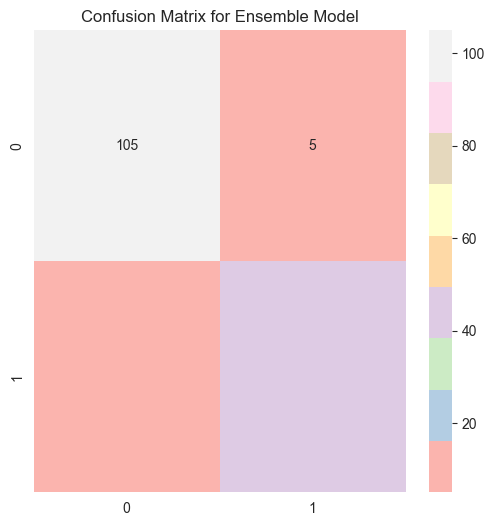

Cross-Validation Scores: [0.87878788 0.87878788 0.87878788 0.90625    0.9375    ]
Mean Cross-Validation Score: 0.8960227272727274
1/1 [==============================] - 0s 17ms/step
Actual Label: No PCOS
Predicted Label: PCOS


In [14]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Loading Data
file_path_with_infertility = "D:\\PatientDisease\\PCOS_infertility.csv"
file_path_without_infertility = "D:\\PatientDisease\\PCOS_data_without_infertility.xlsx"

PCOS_inf = pd.read_csv(file_path_with_infertility)
PCOS_woinf = pd.read_excel(file_path_without_infertility, sheet_name="Full_new")

# Merging the two files as per patient file no. and dropping the repeated features
data = pd.merge(PCOS_woinf, PCOS_inf, on='Patient File No.', suffixes={'','_y'}, how='left')
data = data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y',
                  'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)

# Dealing with categorical values and missing data
data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')
data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(), inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(), inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(), inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(), inplace=True)

# Assigning features (X) and target (y)
X = data.drop(["PCOS (Y/N)", "Sl. No", "Patient File No."], axis=1)
y = data["PCOS (Y/N)"]

# Splitting the data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling the data for all models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
learning_rate = 1e-5  # Example value, adjust as needed
optimizer = Adam(learning_rate=learning_rate)
# ANN Model
# Define the ANN model with Dropout and Batch Normalization
ann_model = Sequential()

# Adding input layer and first hidden layer with Batch Normalization and Dropout
ann_model.add(Dense(units=64, activation='relu', input_dim=X_train_scaled.shape[1]))
ann_model.add(BatchNormalization())
ann_model.add(Dropout(0.3))

# Adding second hidden layer
ann_model.add(Dense(units=32, activation='relu'))
ann_model.add(Dropout(0.3))

# Adding the output layer (for binary classification)
ann_model.add(Dense(units=1, activation='sigmoid'))

# Compiling the ANN
ann_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training the ANN on the training set
ann_model.fit(X_train_scaled, y_train, batch_size=64, epochs=2000, validation_split=0.2)

# Making predictions from ANN model
y_pred_ann = ann_model.predict(X_test_scaled)
y_pred_ann = (y_pred_ann > 0.5).astype(int)  # Convert probabilities to binary 0 or 1

# XGBoost Model
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001, 1e-5],  # Different learning rates
    'n_estimators': [100, 200, 300],  # Number of trees/boosting rounds
    'max_depth': [3, 5, 7, 10],  # Max depth of trees
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight (hessian)
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used per tree
    'colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features used per tree
    'gamma': [0, 0.1, 0.2, 0.3]  # Minimum loss reduction to partition
}

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Initialize the GridSearchCV object
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring='accuracy',  # You can change to 'roc_auc', 'f1' depending on your goal
    cv=3,  # 3-fold cross-validation
    verbose=1,  # Print progress during search
    n_jobs=-1  # Use all cores
)

# Fit the model with the hyperparameter search
xgb_grid_search.fit(X_train_scaled, y_train)

# Get the best XGBoost model from GridSearchCV
best_xgb_model = xgb_grid_search.best_estimator_

# Making predictions from the tuned XGBoost model
y_pred_xgb = best_xgb_model.predict(X_test_scaled)

# Print the best hyperparameters found
print(f"Best Hyperparameters for XGBoost: {xgb_grid_search.best_params_}")

# Random Forest Model
# Hyperparameter Tuning for Random Forest using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [5, 10, 15],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [2, 4, 8]  # Minimum number of samples required to be at a leaf node
}

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters from GridSearchCV
best_rf_model = rf_grid_search.best_estimator_

# Making predictions from the tuned Random Forest model
y_pred_rf = best_rf_model.predict(X_test_scaled)

# Stacking the models
# Step 1: Stack predictions from ANN, XGBoost, and Random Forest models as new features
stacked_predictions = np.column_stack((y_pred_ann, y_pred_xgb, y_pred_rf))

# Step 2: Train the meta-model (Logistic Regression)
meta_model = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000)
meta_model.fit(stacked_predictions, y_test)

# Step 3: Make predictions using the meta-model
meta_predictions = meta_model.predict(stacked_predictions)

# Step 4: Evaluate the ensemble model
accuracy_ensemble = accuracy_score(y_test, meta_predictions)
print(f'Ensemble Model Accuracy: {accuracy_ensemble}')

# Classification report for the ensemble model
class_report_ensemble = classification_report(y_test, meta_predictions)
print("Ensemble Model Classification Report:")
print(class_report_ensemble)

# Confusion matrix for the ensemble model
plt.figure(figsize=(6,6))
cf_matrix_ensemble = confusion_matrix(y_test, meta_predictions)
sns.heatmap(cf_matrix_ensemble, annot=True, cmap="Pastel1", fmt='g')
plt.title('Confusion Matrix for Ensemble Model')
plt.show()

# Cross-validation to ensure the model's robustness
cv_scores = cross_val_score(meta_model, stacked_predictions, y_test, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Cross-Validation Score: {np.mean(cv_scores)}')

# Example: Show the actual and predicted value for a single test row
single_test_index = 3 # You can choose any index from the test set
single_test_data = X_test_scaled[single_test_index:single_test_index+1]

# Predicting the probability for the single test row using the ANN and XGBoost
single_pred_ann = ann_model.predict(single_test_data)
single_pred_xgb = best_xgb_model.predict_proba(single_test_data)
single_pred_rf = best_rf_model.predict_proba(single_test_data)

# Combining predictions for the single test row
stacked_single_test = np.column_stack((single_pred_ann > 0.5, single_pred_xgb[:,1], single_pred_rf[:,1]))

# Final prediction using the meta-model
single_meta_pred = meta_model.predict(stacked_single_test)

# Getting the actual label for the same test row
actual_label = y_test.iloc[single_test_index]
actual_label_str = "PCOS" if actual_label == 1 else "No PCOS"
pred_label_str = "PCOS" if single_meta_pred == 1 else "No PCOS"

flag=False
# Displaying both actual and predicted labels
print(f"Actual Label: {actual_label_str}")
print(f"Predicted Label: {pred_label_str}")
if pred_label_str=="PCOS":
    flag=True


In [ ]:
!pip install cohere requests beautifulsoup4 lxml

In [16]:
import cohere
import requests
import json
from bs4 import BeautifulSoup
import dotenv
import os
# importing necessary functions from dotenv library
from dotenv import load_dotenv, dotenv_values
# loading variables from .env file
load_dotenv()

co = cohere.Client(api_key=os.getenv("API_KEY"))
co

In [17]:
if flag:
    with open(r'D:\PatientDisease\queries.json', 'r') as f:
        data = json.load(f)

    def extract_patient_data(n):
        try:
            query = data[n]
            # Extract relevant fields from the JSON object
            patient_context = query["profile_context"]
            latest_query = "\n".join([f"{q['role']}: {q['content']}" for q in query['latest_query']])
            ideal_response = query["ideal_response"]
            diet_chart = patient_context["diet_chart"]
    
            # Extract and format notes if available
            try:
                notes_html = diet_chart.get("notes", "")
                soup = BeautifulSoup(notes_html, "lxml")
                formatted_notes = soup.get_text(separator="\n").strip()
                diet_chart["notes"] = formatted_notes
            except:
                pass
    
            # Collect meal information by day
            meals_info = []
            meals_by_days = diet_chart.get("meals_by_days", [])
            for day in meals_by_days:
                day_info = {"Day": day['order'], "Meals": []}
                meals = day.get("meals", [])
                for meal in meals:
                    meal_details = {
                        "Meal ID": meal['id'],
                        "Meal Name": meal['name'],
                        "Meal Timings": meal['timings'],
                        "Meal Options": []
                    }
                    meal_options = meal.get("meal_options", [])
                    for option in meal_options:
                        option_details = {
                            "Option ID": option['id'],
                            "Option Notes": option['notes'],
                            "Food Items": [
                                {
                                    "Food ID": food_item['food_id'],
                                    "Measure ID": food_item['food_measure_id']
                                }
                                for food_item in option.get("meal_option_food_items", [])
                            ]
                        }
                        meal_details["Meal Options"].append(option_details)
                    day_info["Meals"].append(meal_details)
                meals_info.append(day_info)
    
            return {
                "patient_context": patient_context,
                "latest_query": latest_query,
                "ideal_response": ideal_response,
                "diet_chart": diet_chart,
                "meals_info": meals_info
            }
        except Exception as e:
            raise e

    def suggest_meal(patient_index, custom_query):
        # Extract patient data
        patient_data = extract_patient_data(patient_index)
    
        # Construct the input for Cohere model based on the custom query and extracted data
        input_text = (
            f"Patient Dietary Information:\n"
            f"{patient_data['latest_query']}\n\n"
            f"Dietary Notes:\n"
            f"{patient_data['diet_chart'].get('notes', 'No specific notes')}\n\n"
            f"Meals by Day:\n"
        )
        for day in patient_data["meals_info"]:
            input_text += f"\nDay {day['Day']}:\n"
            for meal in day["Meals"]:
                input_text += f"  {meal['Meal Name']} at {meal['Meal Timings']}:\n"
                for option in meal["Meal Options"]:
                    input_text += f"    Option Notes: {option['Option Notes']}\n"
                    input_text += "      Food Items:\n"
                    for food in option["Food Items"]:
                        input_text += f"        Food ID: {food['Food ID']}, Measure ID: {food['Measure ID']}\n"
    
        # Append custom query for personalized meal suggestion
        prompt = f"{input_text}\n\nUser Query: {custom_query}\n\nGenerate a detailed and formatted meal suggestion based on the query and dietary data provided."
    
        # Use Cohere API to generate a response
        response = co.generate(
            model='command-xlarge-nightly',
            prompt=prompt,
            max_tokens=500,
            temperature=0.7,
            k=0,
            p=0.75,
            stop_sequences=["--"]
        )
    
        # Clean up and format the output
        suggestion_text = response.generations[0].text.strip()
    
        # Print in a clean, formatted style
        print("Meal Suggestion for PCOS:\n")
        print(suggestion_text.replace("**", "").replace("*", "").strip())

    patient_index = 0  # Specify the index of the patient profile
    custom_query = input("Enter your meal-related question: ")
    
    # Generate a meal suggestion based on the user's custom query
    suggest_meal(patient_index, custom_query)

Meal Suggestion for PCOS:

High-Protein Breakfast Option for PCOS

Here is a meal suggestion tailored to your dietary needs and preferences:

Day 1:
- Early Morning (06:30 AM):
   - Fenugreek (Methi) Water: Soak 1 teaspoon of fenugreek seeds in 1 glass of water overnight. In the morning, boil the water, strain, and drink at room temperature. Fenugreek aids in reducing bloating and excess water weight.
- Breakfast (08:30 AM):
   - Poha: Cook 1 cup of flattened rice with a generous portion of chopped vegetables.
   - Milk: Have 1 glass of milk without sugar after 25 minutes.
- Mid-Morning Snack (11:00 AM):
   - Apple: Enjoy a medium-sized apple.
   - Seeds: Sprinkle a mix of sunflower and flax seeds on the fruit.
- Lunch (01:30 PM):
   - Oats Roti: Make roti with a 50:50 mix of oats flour and whole wheat flour.
   - Curd: Include a bowl of curd for probiotics and gut health.
   - Vegetable Curry: Prepare a curry with seasonal vegetables.
- Evening Snack (05:00 PM):
   - Tea: Have a cup o